In [ ]:
import graph_tool.all as gt
import networkx as nx
import matplotlib.pyplot as plt
import math
import random
import pickle
import datetime
import numpy as np
import re
import glob
random.seed(2022)
gt.openmp_set_schedule("auto")

In [ ]:
data_dir = "data/"
experiment_dir = "experiment/"
exp_shuffles = "exp_shuffles/"
data_filenames = ["mouse_vc","ecoli2k","yeast8k","bc","fbego2","pydep2"]
data_filenames_big = ["bc","fbego2","pydep2"]
names = ["Mouse","E. Coli", "Yeast", "Bitcoin", "Facebook","Python"]
shuffle_names = ["erdos","configuration"]

In [ ]:
def motif_list_contains(motif_list:list, subgraph:gt.Graph()):
    for (i,motif) in enumerate(motif_list):
        if gt.isomorphism(motif,subgraph):
            return i
    return -1

## Number of Shuffles Performance Degradation Analysis
1. Load Ground Truth (100 shuffles)
2. Load Samples (75,56,42,30,20)
4. Compute average percentage variation from 100 shuffles across all motifs, where the percentage refers to the most significant motif. 

In [ ]:
samples_sizes = [75,56,42,30,20]

### Experiment Computation

In [ ]:
iterlist = [75,56,42,30,20]
for fname in data_filenames:
    if fname in data_filenames_big:
        continue
    now = datetime.datetime.now()
    stamp = f"{'{:02d}'.format(now.day)}{'{:02d}'.format(now.month)}_{'{:02d}'.format(now.hour)}{'{:02d}'.format(now.minute)}"

    print(f"{datetime.datetime.now()}  :start {fname}")

    motif_size = 3
    in_path = f"{data_dir}{fname}.graphml"
    out_name = f"exp_shuffles/{fname}-{motif_size}"

    graph = gt.load_graph(in_path)
    gt.remove_self_loops(graph)

    sname="configuration"
    for n_shuffles in iterlist:
        print(f"{datetime.datetime.now()}  :start in-loop {fname}")
        res = gt.motif_significance(graph,motif_size,full_output=True,n_shuffles=n_shuffles)
        out_path = f"{out_name}-{n_shuffles}.pickle"
        with open(out_path,mode='wb') as out:
            pickle.dump(res,out)
        print(f"{datetime.datetime.now()}  :end {fname}-{sname}")
    

In [ ]:
# LOAD N SHUFFLES EXPERIMENTS
root = f"./exp_shuffles"
exp_shuffles = "exp_shuffles/"
theglob = glob.iglob(pathname="*.pickle",root_dir=root)
names_or = "|".join(data_filenames)
k_pattern = "-[0-9]-"
n_pattern = "-[0-9][0-9]\."
shuffles_or = "|".join(shuffle_names)
und_pattern = "(-UND)"
count_pattern = "(-COUNT)"

datasets_shuffles = data_filenames[0:3]+["fbego2"]
#INIT MAP
samples_map = dict()
for s in samples_sizes:
    samples_map[s] = dict()
    for dataset in datasets_shuffles:
        samples_map[s][dataset] = dict()
#LOAD SAMPLES
for result in theglob:
    dataset = re.search(pattern=names_or,string= result).group(0)
    k = re.search(pattern=k_pattern,string= result).group(0).replace("-","")
    n_shuf = re.search(pattern=n_pattern,string= result).group(0).replace("-","").replace(".","")
    print(dataset,n_shuf)
    res = None
    with open(root+"/"+result,'rb') as f:
        res = pickle.load(f)
    s = int(n_shuf)
    samples_map[s][dataset]["motifs"] = res[0]
    samples_map[s][dataset]["results"] = res[1]

In [ ]:
# LOAD GROUND TRUTH
ground_truth = dict()
for dataset in datasets_shuffles:
    ground_truth[dataset] = dict()
for dataset in glob.glob("*3-configuration*[0-9].pickle",root_dir="experiment/"):
    # print(dataset)
    for dp in data_filenames:
        if dp in data_filenames_big:
            continue
        if str(dataset).startswith(dp):
            res = None
            with open(experiment_dir+dataset,'rb') as f:
                res = pickle.load(f)
            ground_truth[dp]["motifs"] = res[0]
            ground_truth[dp]["results"] = res[1]

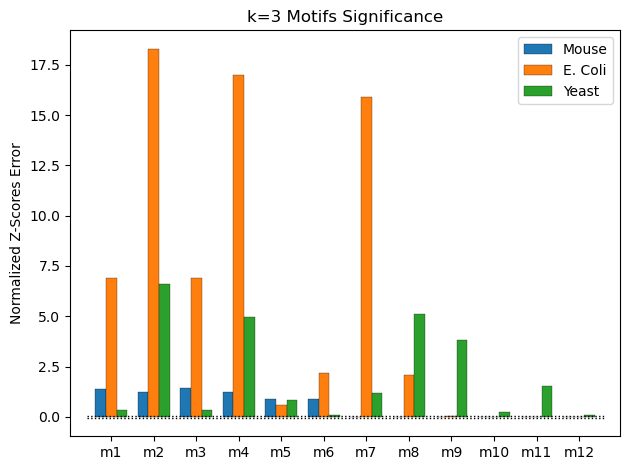

In [ ]:
# DIRECTED MOTIFS OF SIZE 3 - CONFIGURATION
k_motif_size = 3
k_key = "3"
tag = "directed"

global_list = list()
max_list = list()
max_size = 0
max_name = ""
# FIND BIGGER MOTIF LIST
for a_dataset in datasets_shuffles:
    curr_list = ground_truth[a_dataset]["motifs"]
    curr_size = len(curr_list)
    if curr_size > max_size:
        max_list = curr_list
        max_name = a_dataset
        max_size = curr_size
global_list = max_list
# ADD MISSING IF ANY
for a_dataset in datasets_shuffles:
    curr_list = ground_truth[a_dataset]["motifs"]
    for a_motif in curr_list:
        if motif_list_contains(global_list,a_motif) < 0:
            print(f"found missing motif from {a_dataset}")
            global_list.append(a_motif)

# EXPAND RESULTS AND PLOT
normalize = True

n = np.arange(len(global_list))
labels = list()
for i in range(1,len(global_list)+1):
    labels += [f"m{i}"]
fig, ax = plt.subplots()
n_bars = len(datasets_shuffles)
width = 1.0/(n_bars+1)
off = 0 - (width*(n_bars-1)/2)
for (a_dataset,a_name) in zip(datasets_shuffles,names[0:3]):
    gt_results = [0] * len(global_list)
    dataset_errors = [0.0] * len(global_list)
    curr_list = ground_truth[a_dataset]["motifs"]
    curr_results = ground_truth[a_dataset]["results"]
    exp_labels = [0] * len(global_list)
    # Normalize Ground Truth
    max_val_gt = 0
    for zscore in curr_results:
        if abs(zscore) > max_val_gt:
            max_val_gt = abs(zscore)
    for j in range(0,len(curr_list)):
        global_index = motif_list_contains(global_list,curr_list[j])
        if normalize:
            gt_results[global_index] = curr_results[j]/max_val_gt if max_val_gt > 1 else curr_results[j]
        else:
            gt_results[global_index] = curr_results[j]
        exp_labels[global_index] = curr_results[j]
    for s in samples_sizes:
        sample_motifs = samples_map[s][a_dataset]["motifs"]
        sample_results = samples_map[s][a_dataset]["results"]
        for j in range(0,len(sample_motifs)):
            gt_index = motif_list_contains(global_list,sample_motifs[j])
            current_index = motif_list_contains(curr_list,sample_motifs[j])
            if gt_index<0:
                print(f"Motif {sample_motifs[j]} not in the global list")
            sample_value = sample_results[j]/max_val_gt if normalize else sample_results[j]
            delta_err = (1/len(samples_sizes)) * abs(sample_value - curr_results[current_index])
            dataset_errors[gt_index] += delta_err 
    r = ax.bar(n+off,dataset_errors,align="center",width=width,edgecolor="black",linewidth=0.2,label=a_name)
    # ax.bar_label(r,labels= exp_labels,fmt='%.1f',padding=2.5)
    off = off + width
ax.set_ylabel('Normalized Z-Scores Error')
ax.set_title('k=3 Motifs Significance')
ax.set_xticks(n, labels)
ax.axhline(y=0.05,linestyle="dotted",linewidth=1,color = "black", xmin=0.03,xmax=0.97)
ax.axhline(y=-0.05,linestyle="dotted",linewidth=1,color = "black", xmin=0.03,xmax=0.97)
ax.legend()
fig.tight_layout()
plt.show()
# for g,mane in zip(global_list,n):
#     gt.graph_draw(g,output_size=(200,200),bg_color="white",output=f"./configuration_dir_3//m{mane+1}.png")

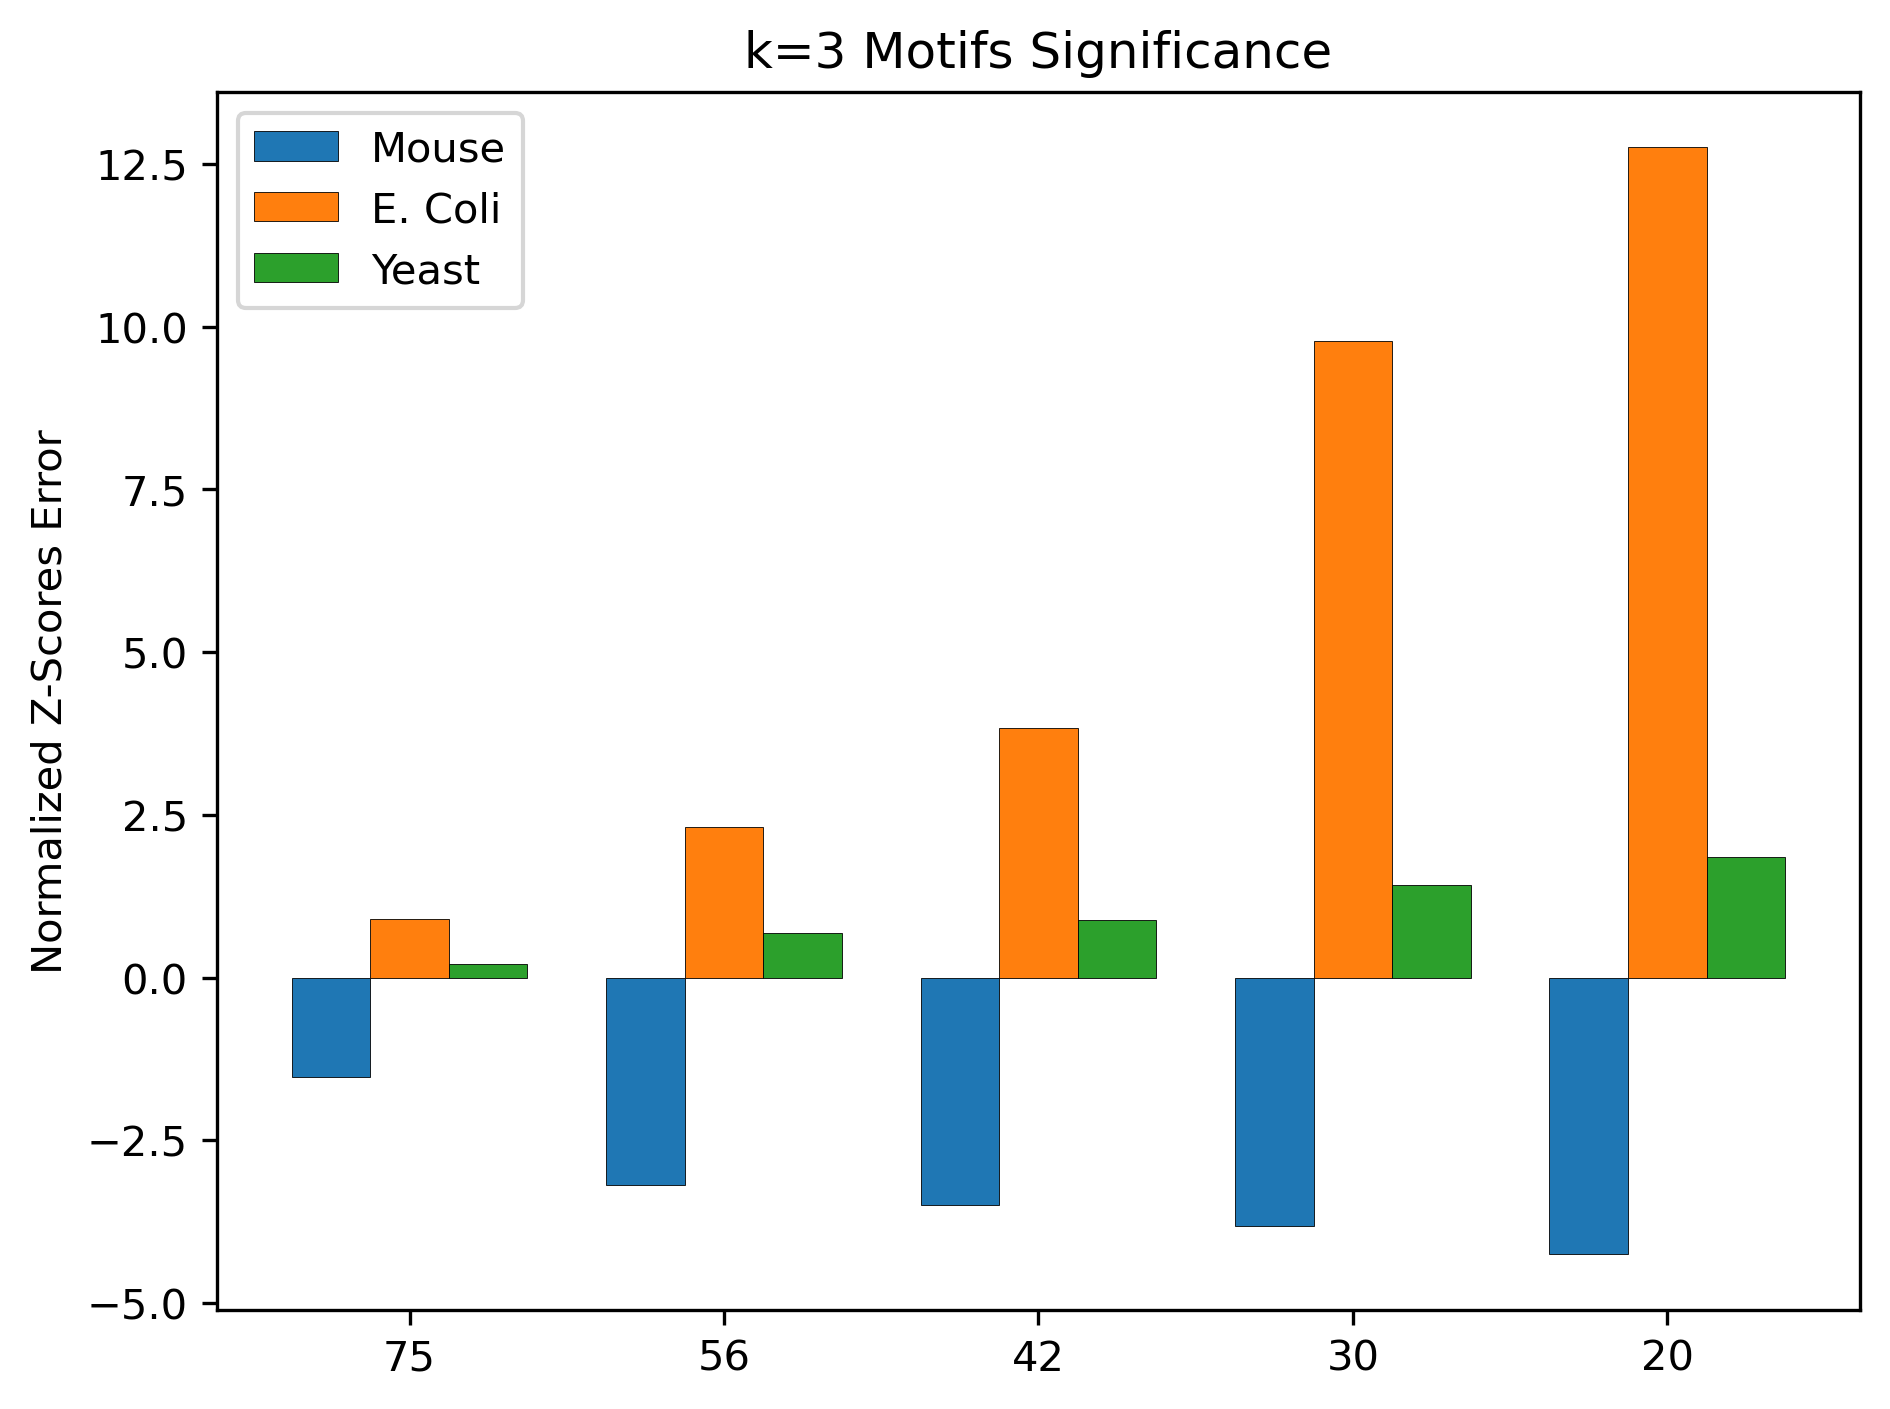

In [ ]:
# DIRECTED MOTIFS OF SIZE 3 - CONFIGURATION
k_motif_size = 3
k_key = "3"
tag = "directed"
plt.rcParams['figure.dpi'] = 300

global_list = list()
max_list = list()
max_size = 0
max_name = ""
# FIND BIGGER MOTIF LIST
for a_dataset in datasets_shuffles:
    curr_list = ground_truth[a_dataset]["motifs"]
    curr_size = len(curr_list)
    if curr_size > max_size:
        max_list = curr_list
        max_name = a_dataset
        max_size = curr_size
global_list = max_list
# ADD MISSING IF ANY
for a_dataset in datasets_shuffles:
    curr_list = ground_truth[a_dataset]["motifs"]
    for a_motif in curr_list:
        if motif_list_contains(global_list,a_motif) < 0:
            print(f"found missing motif from {a_dataset}")
            global_list.append(a_motif)

# EXPAND RESULTS AND PLOT
normalize = True

n = np.arange(len(global_list))
labels = list()
for i in range(1,len(global_list)+1):
    labels += [f"m{i}"]
fig, ax = plt.subplots()
n_bars = len(datasets_shuffles)
width = 1.0/(n_bars+1)
off = 0 - (width*(n_bars-1)/2)
n = np.arange(len(samples_sizes))
labels = list()
for i in range(0,len(samples_sizes)):
    labels += [f"{samples_sizes[i]}"]
width = 1.0/(n_bars+1)
off = 0 - (width*(n_bars-1)/2)
for (a_dataset,a_name) in zip(datasets_shuffles,names[0:3]):
    gt_results = [0] * len(global_list)
    dataset_errors = [0.0] * len(global_list)
    weighted_dataset_errors = [0.0] * len(global_list)

    cumulative = [0.0]*len(samples_sizes)
    cumulative_weighted = [0.0]*len(samples_sizes)
    
    curr_list = ground_truth[a_dataset]["motifs"]
    curr_results = ground_truth[a_dataset]["results"]
    ground_truth_results = ground_truth[a_dataset]["results"]
    exp_labels = [0] * len(global_list)
    # Normalize Ground Truth
    max_val_gt = 0
    for zscore in curr_results:
        if abs(zscore) > max_val_gt:
            max_val_gt = abs(zscore)
    for j in range(0,len(curr_list)):
        global_index = motif_list_contains(global_list,curr_list[j])
        if normalize:
            gt_results[global_index] = curr_results[j]/max_val_gt if max_val_gt > 1 else curr_results[j]
        else:
            gt_results[global_index] = curr_results[j]
        exp_labels[global_index] = curr_results[j]
    off2 = 0.01
    for i,s in enumerate(samples_sizes):
        samples_errors = [0.0] * len(global_list)
        sample_motifs = samples_map[s][a_dataset]["motifs"]
        sample_results = samples_map[s][a_dataset]["results"]
        for j,motif in enumerate(global_list):
            aa = motif_list_contains(sample_motifs,motif)
            bb = motif_list_contains(curr_list,motif)
            if aa < 0 and bb >0:
                samples_errors[j] = abs(curr_results[bb])
                dataset_errors[j] += (1/len(samples_sizes)) * samples_errors[j]
        for j in range(0,len(sample_motifs)):
            gt_index = motif_list_contains(global_list,sample_motifs[j])
            current_index = motif_list_contains(curr_list,sample_motifs[j])
            if gt_index<0:
                print(f"Motif {sample_motifs[j]} not in the global list")
            sample_value = sample_results[j]/max_val_gt if normalize else sample_results[j]
            delta_err =  abs(sample_value - curr_results[current_index])
            samples_errors[gt_index] = delta_err
            dataset_errors[gt_index] += (1/len(samples_sizes)) * delta_err
            weighted_dataset_errors[gt_index] += abs(ground_truth_results[current_index] - sample_results[j])
        # ax.scatter(n+off+off2, samples_errors, label=s,marker="x")
        off2 += 0.01
        cumulative[i] += np.sum(dataset_errors)/len(global_list)
        cumulative_weighted[i] = np.sum(weighted_dataset_errors)/np.sum(ground_truth_results)
    mmax= np.max(cumulative)
    # for i in range(0,len(samples_sizes)):
    #     cumulative[i] /= mmax
    # r = ax.bar(n+off,cumulative,align="center",width=width,edgecolor="black",linewidth=0.2,label=a_name)
    r = ax.bar(n+off,cumulative_weighted,align="center",width=width,edgecolor="black",linewidth=0.2,label=a_name)
    # ax.bar_label(r,labels= exp_labels,fmt='%.1f',padding=2.5)
    off = off + width


# ax.bar(n+off,cumulative,align="center",width=width,edgecolor="black",linewidth=0.2,label=a_name)
ax.set_ylabel('Normalized Z-Scores Error')
ax.set_title('k=3 Motifs Significance')
ax.set_xticks(n, labels)
ax.legend()
fig.tight_layout()
plt.show()
# for g,mane in zip(global_list,n):
#     gt.graph_draw(g,output_size=(200,200),bg_color="white",output=f"./configuration_dir_3//m{mane+1}.png")

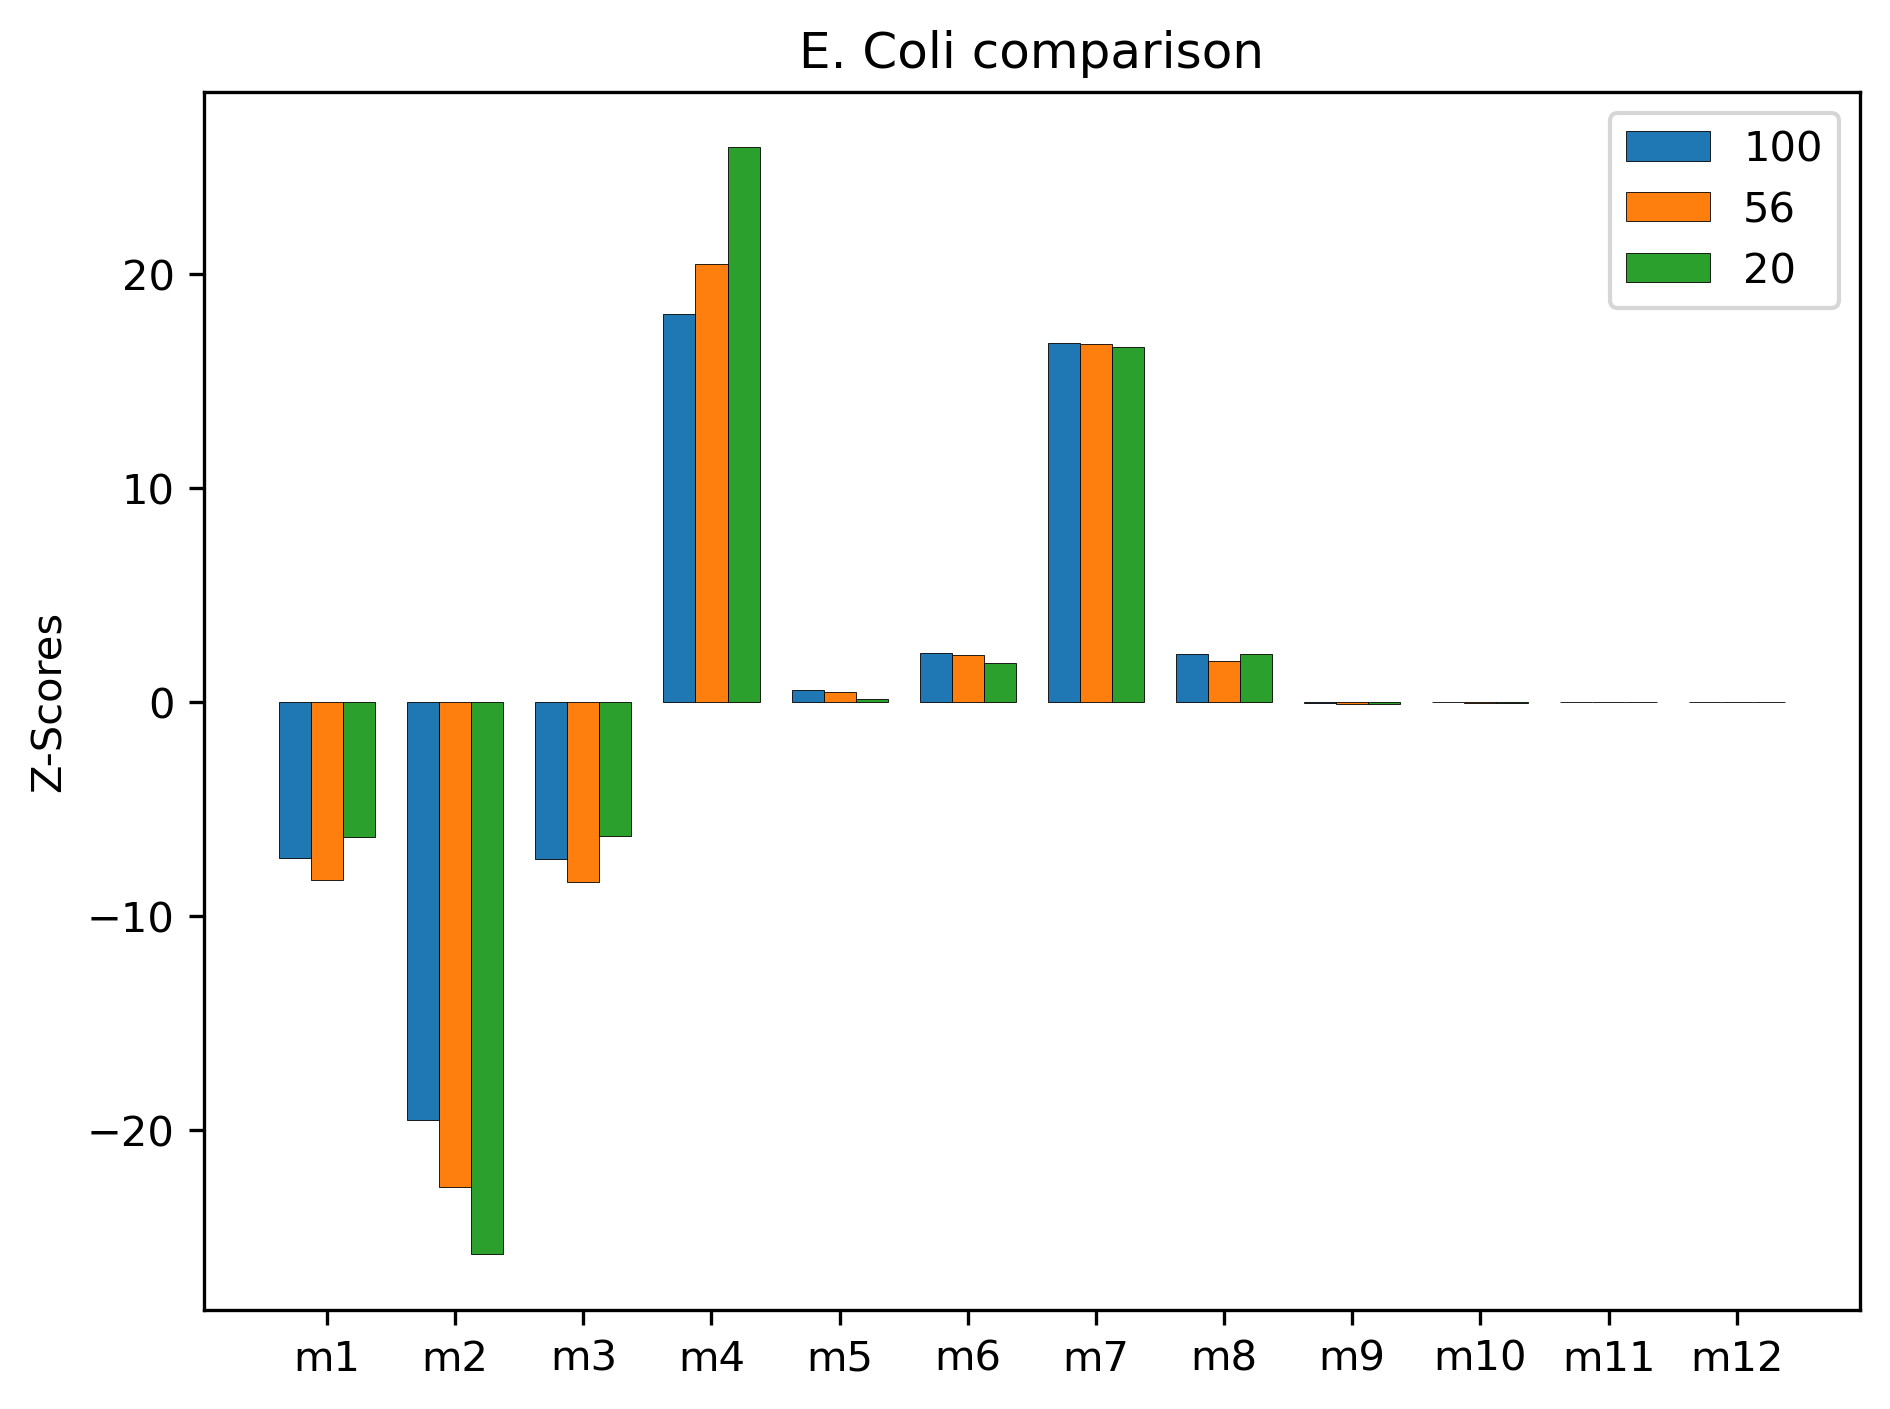

In [ ]:
# DIRECTED MOTIFS OF SIZE 3 - CONFIGURATION
k_motif_size = 3
k_key = "3"
tag = "directed"
plt.rcParams['figure.dpi'] = 300

global_list = list()
max_list = list()
max_size = 0
max_name = ""
# FIND BIGGER MOTIF LIST
for a_dataset in datasets_shuffles:
    curr_list = ground_truth[a_dataset]["motifs"]
    curr_size = len(curr_list)
    if curr_size > max_size:
        max_list = curr_list
        max_name = a_dataset
        max_size = curr_size
global_list = max_list
# ADD MISSING IF ANY
for a_dataset in datasets_shuffles:
    curr_list = ground_truth[a_dataset]["motifs"]
    for a_motif in curr_list:
        if motif_list_contains(global_list,a_motif) < 0:
            print(f"found missing motif from {a_dataset}")
            global_list.append(a_motif)

# EXPAND RESULTS AND PLOT
normalize = False

n = np.arange(len(global_list))
labels = list()
for i in range(1,len(global_list)+1):
    labels += [f"m{i}"]
fig, ax = plt.subplots()
n_bars = 3
width = 1.0/(n_bars+1)
off = 0 - (width*(n_bars-1)/2)

for (a_dataset,a_name) in zip(datasets_shuffles,names[0:3]):
    if a_dataset != "ecoli2k":
        continue
    gt_results = [0] * len(global_list)
    dataset_errors = [0.0] * len(global_list)
    weighted_dataset_errors = [0.0] * len(global_list)

    cumulative = [0.0]*len(samples_sizes)
    cumulative_weighted = [0.0]*len(samples_sizes)
    
    curr_list = ground_truth[a_dataset]["motifs"]
    curr_results = ground_truth[a_dataset]["results"]
    ground_truth_results = ground_truth[a_dataset]["results"]
    exp_labels = [0] * len(global_list)
    # Normalize Ground Truth
    max_val_gt = 0
    for zscore in curr_results:
        if abs(zscore) > max_val_gt:
            max_val_gt = abs(zscore)
    for j in range(0,len(curr_list)):
        global_index = motif_list_contains(global_list,curr_list[j])
        if normalize:
            gt_results[global_index] = curr_results[j]/max_val_gt if max_val_gt > 1 else curr_results[j]
        else:
            gt_results[global_index] = curr_results[j]
        exp_labels[global_index] = curr_results[j]
    for i,s in enumerate([100,56,20]):
        
        samples_errors = [0.0] * len(global_list)
        sample_motifs = curr_list if s == 100 else samples_map[s][a_dataset]["motifs"]
        sample_results = curr_results if s == 100 else samples_map[s][a_dataset]["results"]
        ordered_results = [0.0] * len(global_list)
        
        for j in range(0,len(sample_motifs)):
            gt_index = motif_list_contains(global_list,sample_motifs[j])
            current_index = motif_list_contains(curr_list,sample_motifs[j])
            if gt_index<0:
                print(f"Motif {sample_motifs[j]} not in the global list")
            sample_value = sample_results[j]/max_val_gt if normalize else sample_results[j]
            ordered_results[gt_index] = sample_results[j]
        r = ax.bar(n+off,ordered_results,align="center",width=width,edgecolor="black",linewidth=0.2,label=str(s))
        off = off + width

# ax.bar(n+off,cumulative,align="center",width=width,edgecolor="black",linewidth=0.2,label=a_name)
ax.set_ylabel('Z-Scores')
ax.set_title('E. Coli comparison')
ax.set_xticks(n, labels)
ax.legend()
fig.tight_layout()
plt.show()
# for g,mane in zip(global_list,n):
#     gt.graph_draw(g,output_size=(200,200),bg_color="white",output=f"./configuration_dir_3//m{mane+1}.png")

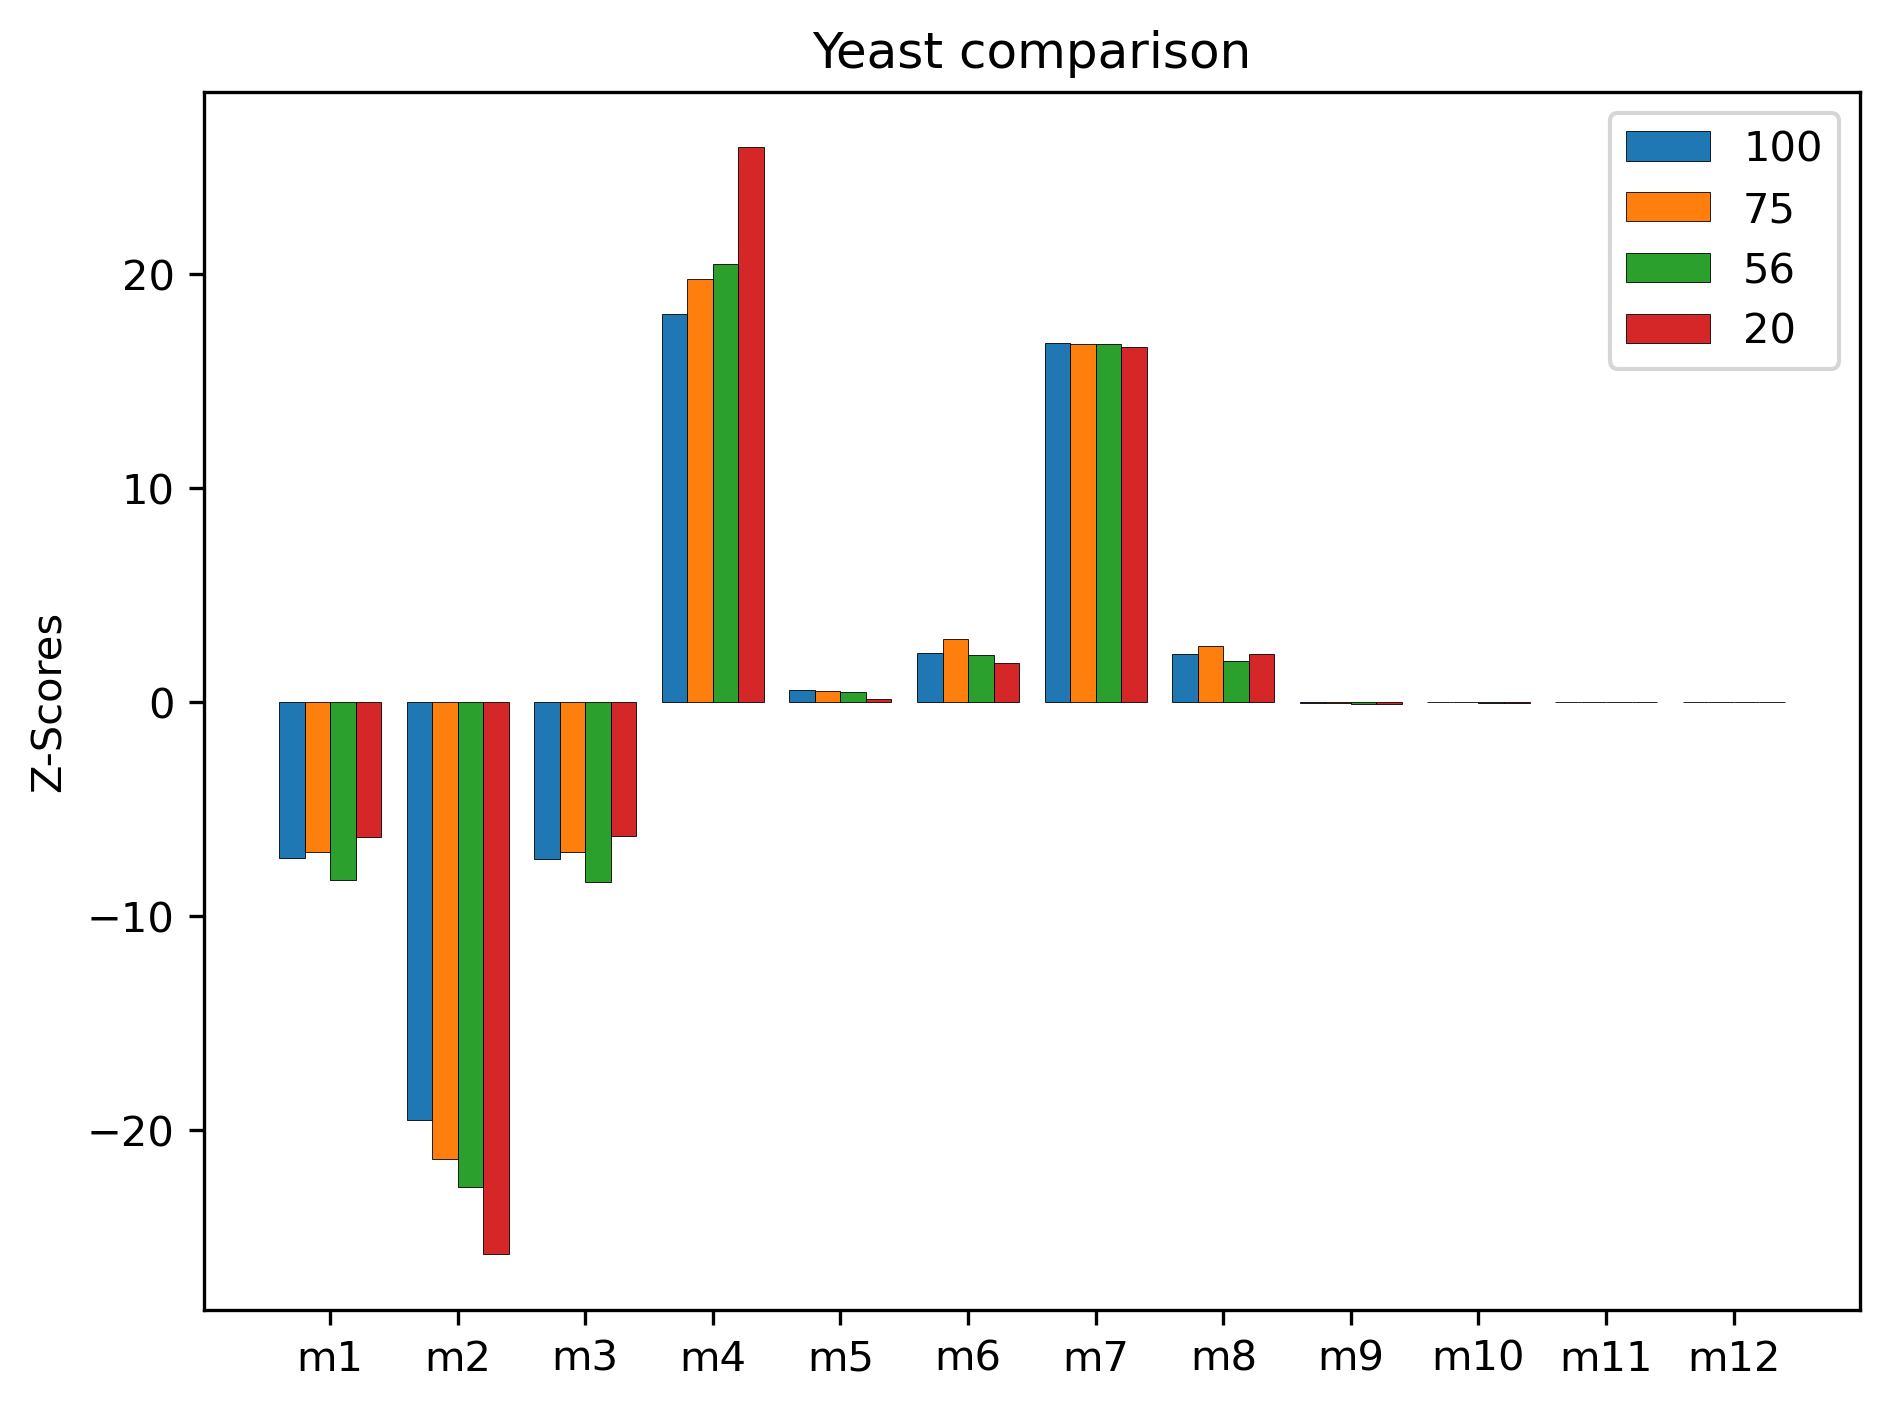

In [ ]:
# DIRECTED MOTIFS OF SIZE 3 - CONFIGURATION
k_motif_size = 3
k_key = "3"
tag = "directed"
plt.rcParams['figure.dpi'] = 300

global_list = list()
max_list = list()
max_size = 0
max_name = ""
# FIND BIGGER MOTIF LIST
for a_dataset in datasets_shuffles:
    curr_list = ground_truth[a_dataset]["motifs"]
    curr_size = len(curr_list)
    if curr_size > max_size:
        max_list = curr_list
        max_name = a_dataset
        max_size = curr_size
global_list = max_list
# ADD MISSING IF ANY
for a_dataset in datasets_shuffles:
    curr_list = ground_truth[a_dataset]["motifs"]
    for a_motif in curr_list:
        if motif_list_contains(global_list,a_motif) < 0:
            print(f"found missing motif from {a_dataset}")
            global_list.append(a_motif)

# EXPAND RESULTS AND PLOT
normalize = False

n = np.arange(len(global_list))
labels = list()
for i in range(1,len(global_list)+1):
    labels += [f"m{i}"]
fig, ax = plt.subplots()
sizes = [100,75,56,20]
n_bars = len(sizes)
width = 1.0/(n_bars+1)
off = 0 - (width*(n_bars-1)/2)
for (a_dataset,a_name) in zip(datasets_shuffles,names[0:3]):
    if a_dataset != "ecoli2k":
        continue
    gt_results = [0] * len(global_list)
    
    curr_list = ground_truth[a_dataset]["motifs"]
    curr_results = ground_truth[a_dataset]["results"]
    ground_truth_results = ground_truth[a_dataset]["results"]
    exp_labels = [0] * len(global_list)
    # Normalize and reorder Ground Truth
    max_val_gt = 0
    for zscore in curr_results:
        if abs(zscore) > max_val_gt:
            max_val_gt = abs(zscore)
    for j in range(0,len(curr_list)):
        global_index = motif_list_contains(global_list,curr_list[j])
        if normalize:
            gt_results[global_index] = curr_results[j]/max_val_gt if max_val_gt > 1 else curr_results[j]
        else:
            gt_results[global_index] = curr_results[j]
        exp_labels[global_index] = curr_results[j]
    for i,s in enumerate(sizes):
        sample_motifs = curr_list if s == 100 else samples_map[s][a_dataset]["motifs"]
        sample_results = curr_results if s == 100 else samples_map[s][a_dataset]["results"]
        ordered_results = [0.0] * len(global_list)
        
        for j in range(0,len(sample_motifs)):
            gt_index = motif_list_contains(global_list,sample_motifs[j])
            current_index = motif_list_contains(curr_list,sample_motifs[j])
            if gt_index<0:
                print(f"Motif {sample_motifs[j]} not in the global list")
            sample_value = sample_results[j]/max_val_gt if normalize else sample_results[j]
            ordered_results[gt_index] = sample_results[j]
        r = ax.bar(n+off,ordered_results,align="center",width=width,edgecolor="black",linewidth=0.2,label=str(s))
        off = off + width

# ax.bar(n+off,cumulative,align="center",width=width,edgecolor="black",linewidth=0.2,label=a_name)
ax.set_ylabel('Z-Scores')
ax.set_title('Yeast comparison')
ax.set_xticks(n, labels)
ax.legend()
fig.tight_layout()
plt.show()
# for g,mane in zip(global_list,n):
#     gt.graph_draw(g,output_size=(200,200),bg_color="white",output=f"./configuration_dir_3//m{mane+1}.png")

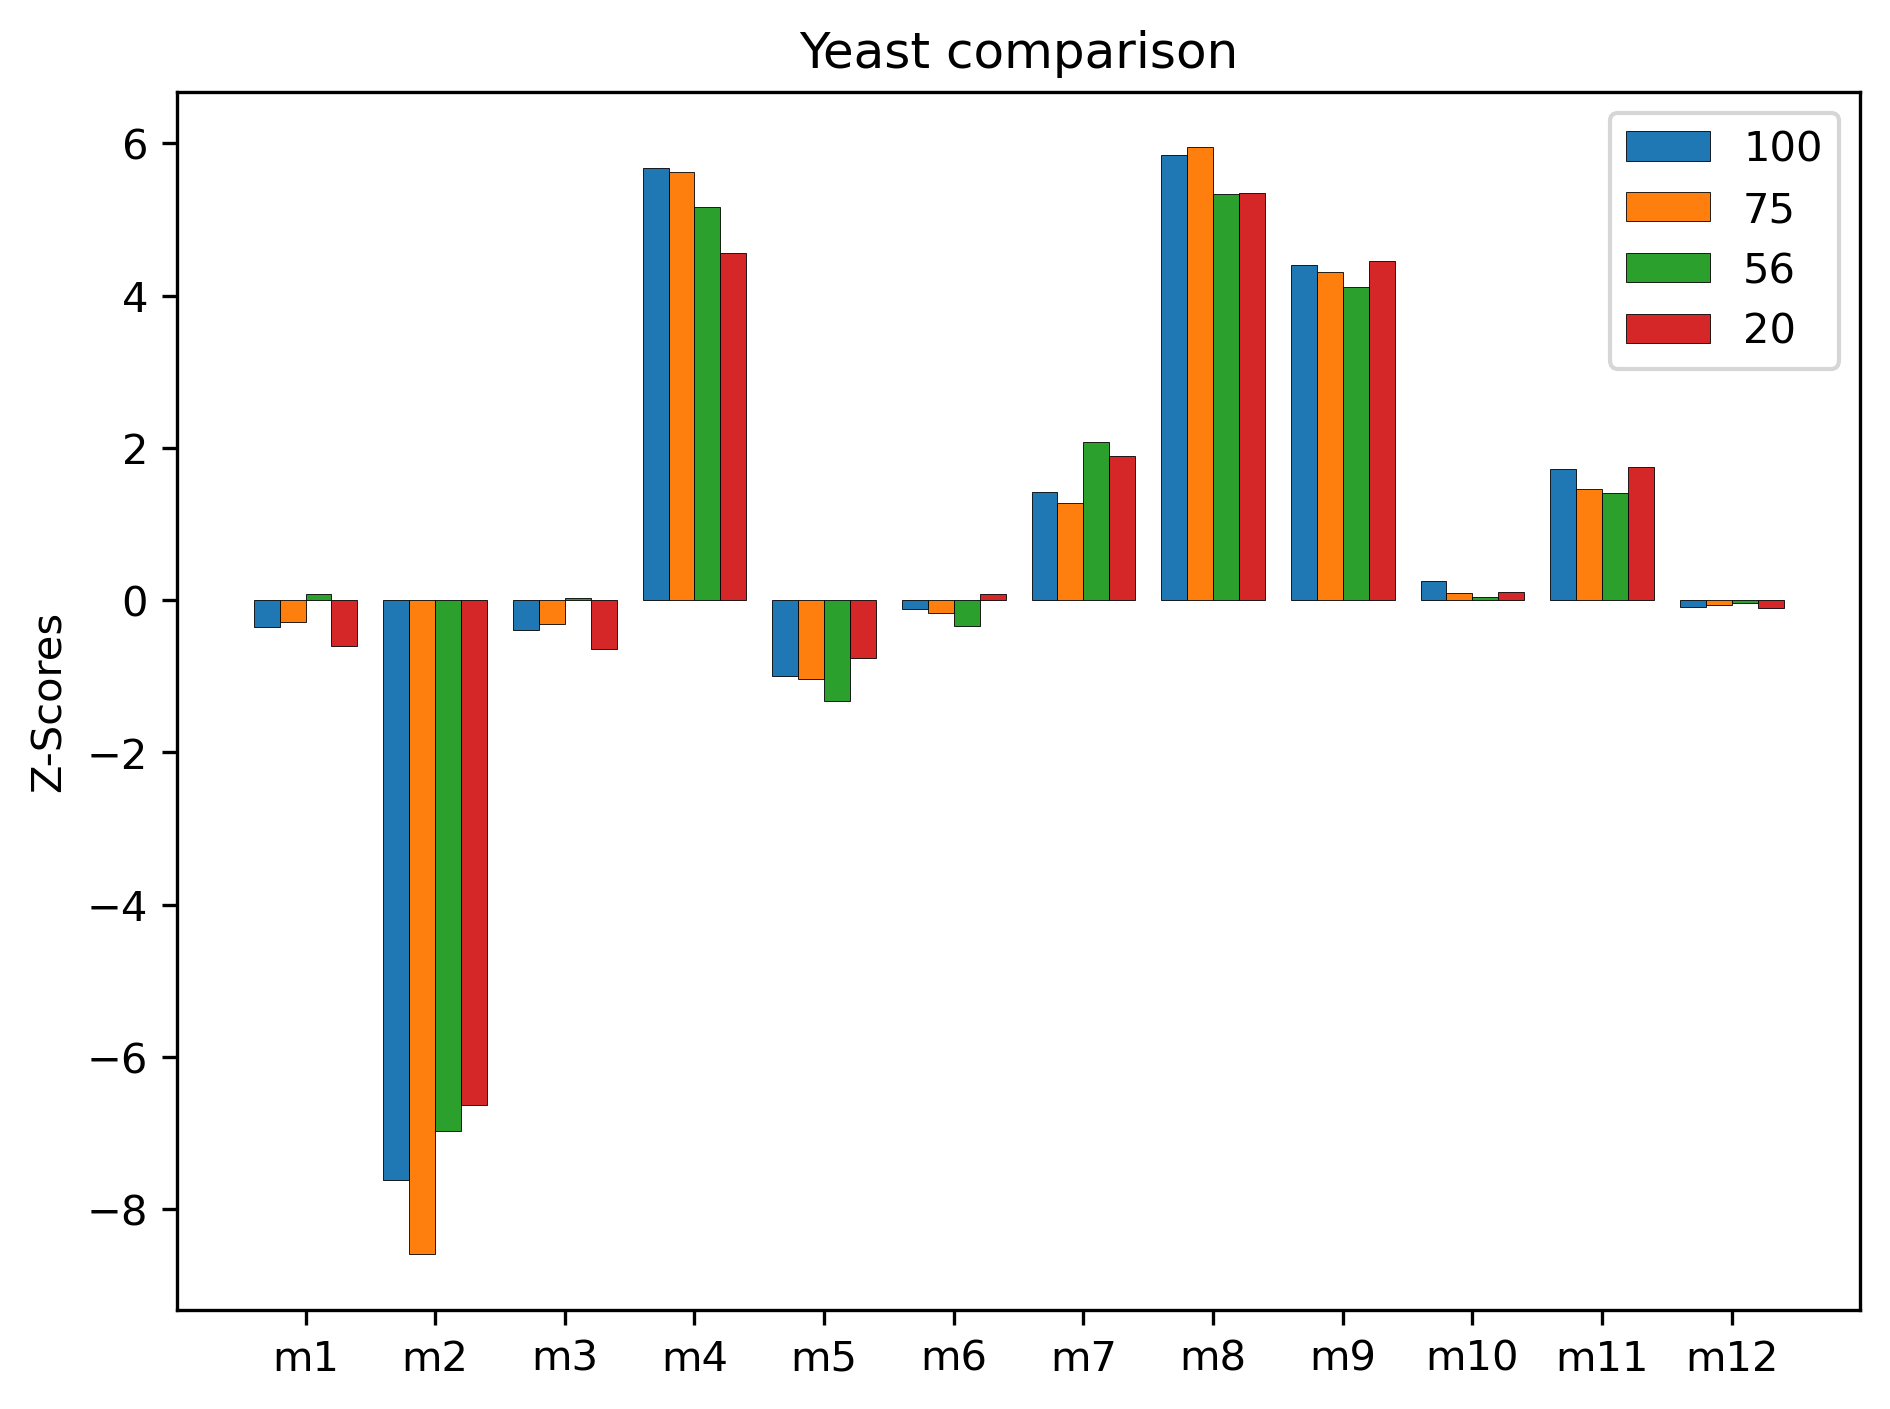

In [ ]:
# DIRECTED MOTIFS OF SIZE 3 - CONFIGURATION
k_motif_size = 3
k_key = "3"
tag = "directed"
plt.rcParams['figure.dpi'] = 300

global_list = list()
max_list = list()
max_size = 0
max_name = ""
# FIND BIGGER MOTIF LIST
for a_dataset in datasets_shuffles:
    curr_list = ground_truth[a_dataset]["motifs"]
    curr_size = len(curr_list)
    if curr_size > max_size:
        max_list = curr_list
        max_name = a_dataset
        max_size = curr_size
global_list = max_list
# ADD MISSING IF ANY
for a_dataset in datasets_shuffles:
    curr_list = ground_truth[a_dataset]["motifs"]
    for a_motif in curr_list:
        if motif_list_contains(global_list,a_motif) < 0:
            print(f"found missing motif from {a_dataset}")
            global_list.append(a_motif)

# EXPAND RESULTS AND PLOT
normalize = False

n = np.arange(len(global_list))
labels = list()
for i in range(1,len(global_list)+1):
    labels += [f"m{i}"]
fig, ax = plt.subplots()
sizes = [100,75,56,20]
n_bars = len(sizes)
width = 1.0/(n_bars+1)
off = 0 - (width*(n_bars-1)/2)
for (a_dataset,a_name) in zip(datasets_shuffles,names[0:3]):
    if a_dataset != "yeast8k":
        continue
    gt_results = [0] * len(global_list)
    
    curr_list = ground_truth[a_dataset]["motifs"]
    curr_results = ground_truth[a_dataset]["results"]
    ground_truth_results = ground_truth[a_dataset]["results"]
    exp_labels = [0] * len(global_list)
    # Normalize and reorder Ground Truth
    max_val_gt = 0
    for zscore in curr_results:
        if abs(zscore) > max_val_gt:
            max_val_gt = abs(zscore)
    for j in range(0,len(curr_list)):
        global_index = motif_list_contains(global_list,curr_list[j])
        if normalize:
            gt_results[global_index] = curr_results[j]/max_val_gt if max_val_gt > 1 else curr_results[j]
        else:
            gt_results[global_index] = curr_results[j]
        exp_labels[global_index] = curr_results[j]
    for i,s in enumerate(sizes):
        sample_motifs = curr_list if s == 100 else samples_map[s][a_dataset]["motifs"]
        sample_results = curr_results if s == 100 else samples_map[s][a_dataset]["results"]
        ordered_results = [0.0] * len(global_list)
        
        for j in range(0,len(sample_motifs)):
            gt_index = motif_list_contains(global_list,sample_motifs[j])
            current_index = motif_list_contains(curr_list,sample_motifs[j])
            if gt_index<0:
                print(f"Motif {sample_motifs[j]} not in the global list")
            sample_value = sample_results[j]/max_val_gt if normalize else sample_results[j]
            ordered_results[gt_index] = sample_results[j]
        r = ax.bar(n+off,ordered_results,align="center",width=width,edgecolor="black",linewidth=0.2,label=str(s))
        off = off + width

# ax.bar(n+off,cumulative,align="center",width=width,edgecolor="black",linewidth=0.2,label=a_name)
ax.set_ylabel('Z-Scores')
ax.set_title('Yeast comparison')
ax.set_xticks(n, labels)
ax.legend()
fig.tight_layout()
plt.show()
# for g,mane in zip(global_list,n):
#     gt.graph_draw(g,output_size=(200,200),bg_color="white",output=f"./configuration_dir_3//m{mane+1}.png")

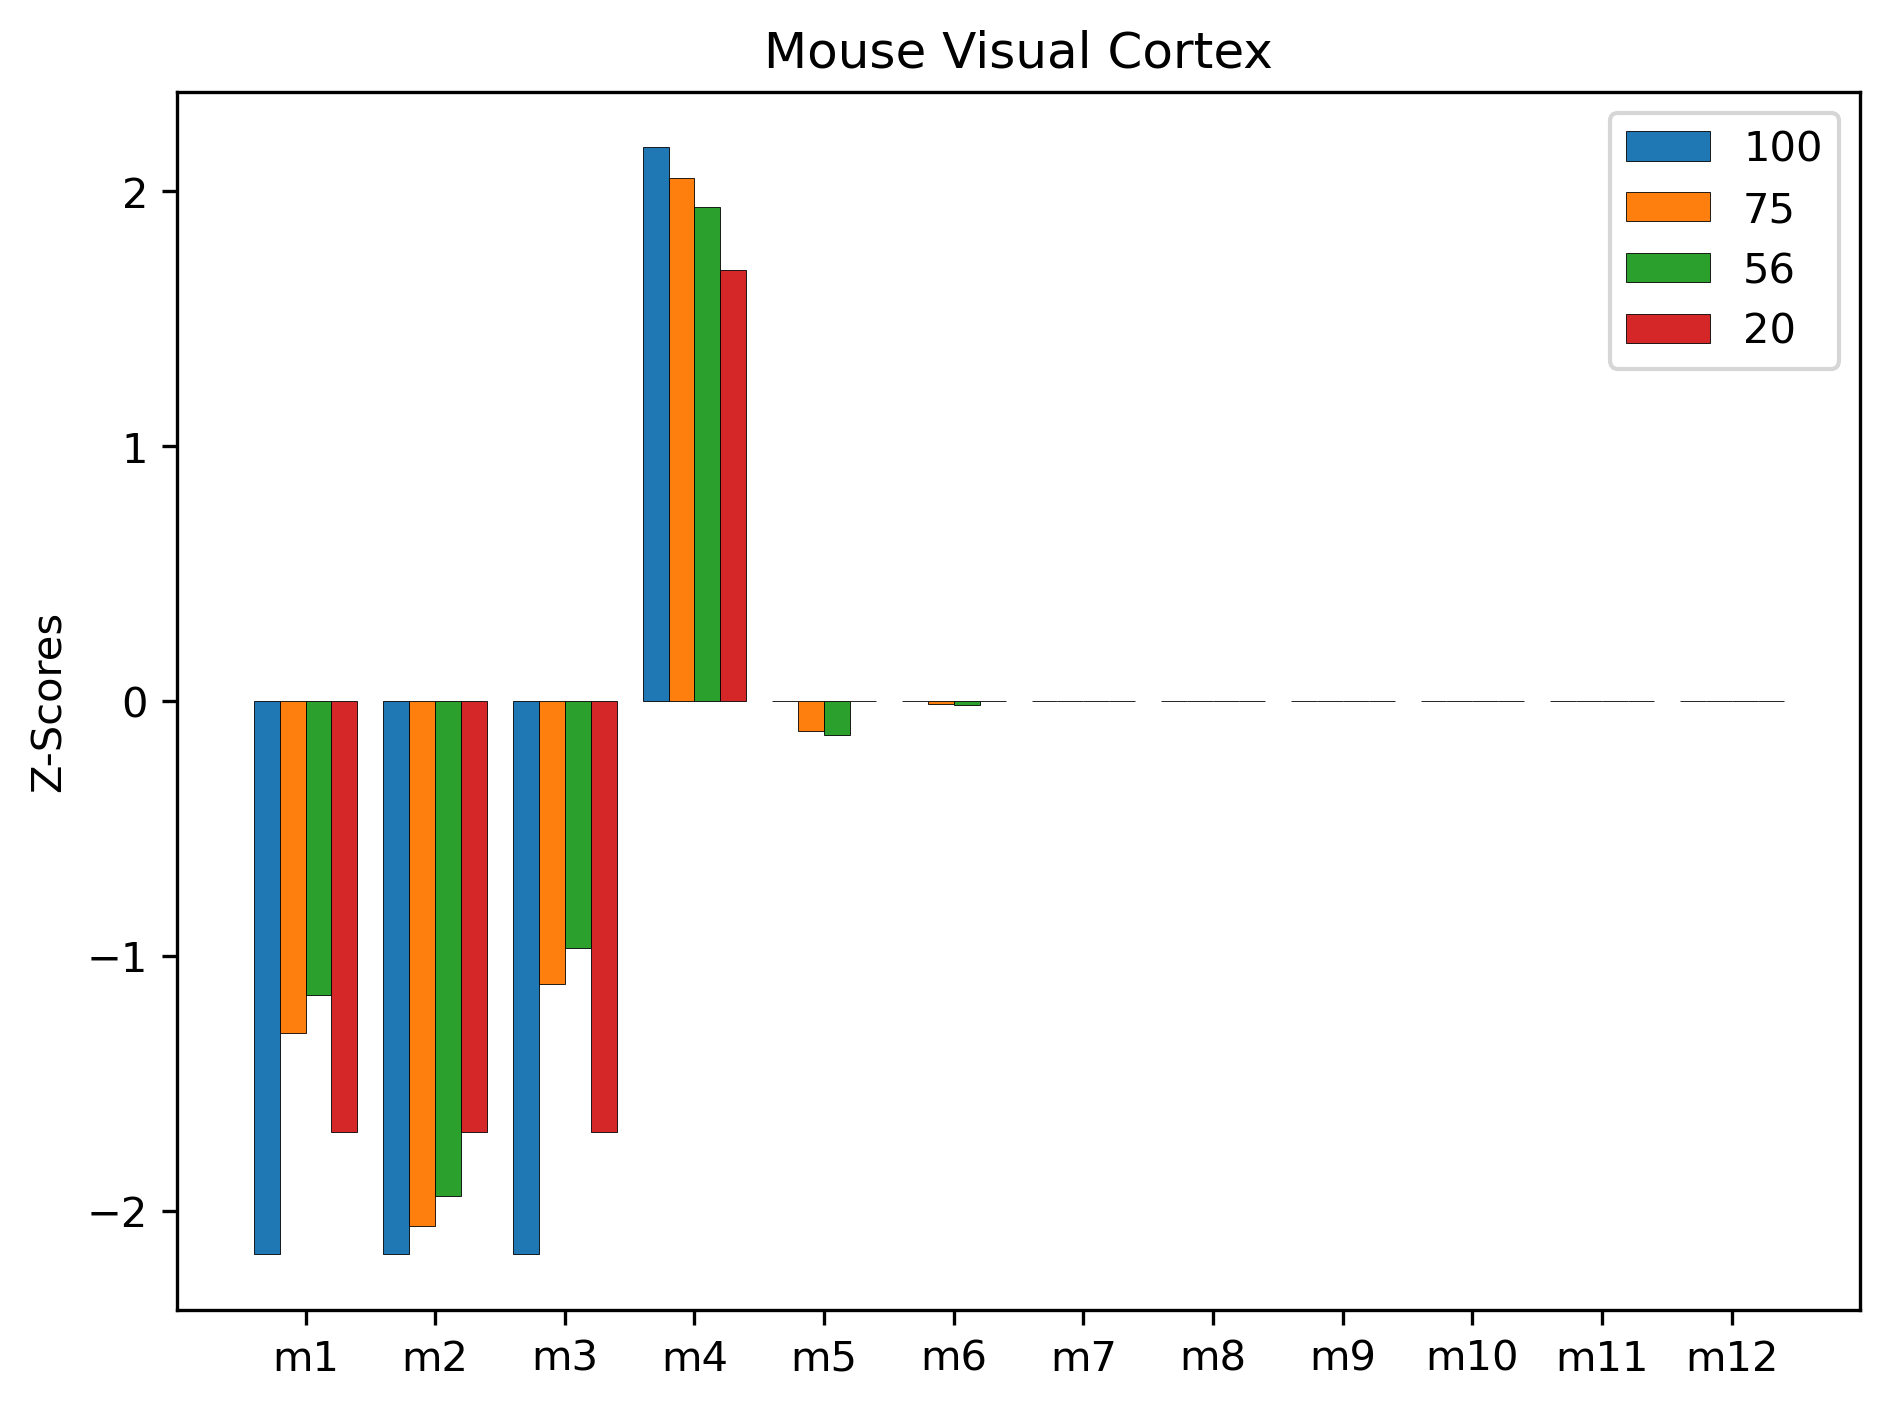

In [ ]:
# DIRECTED MOTIFS OF SIZE 3 - CONFIGURATION
k_motif_size = 3
k_key = "3"
tag = "directed"
plt.rcParams['figure.dpi'] = 300

global_list = list()
max_list = list()
max_size = 0
max_name = ""
# FIND BIGGER MOTIF LIST
for a_dataset in datasets_shuffles:
    curr_list = ground_truth[a_dataset]["motifs"]
    curr_size = len(curr_list)
    if curr_size > max_size:
        max_list = curr_list
        max_name = a_dataset
        max_size = curr_size
global_list = max_list
# ADD MISSING IF ANY
for a_dataset in datasets_shuffles:
    curr_list = ground_truth[a_dataset]["motifs"]
    for a_motif in curr_list:
        if motif_list_contains(global_list,a_motif) < 0:
            print(f"found missing motif from {a_dataset}")
            global_list.append(a_motif)

# EXPAND RESULTS AND PLOT
normalize = False

n = np.arange(len(global_list))
labels = list()
for i in range(1,len(global_list)+1):
    labels += [f"m{i}"]
fig, ax = plt.subplots()
sizes = [100,75,56,20]
n_bars = len(sizes)
width = 1.0/(n_bars+1)
off = 0 - (width*(n_bars-1)/2)
for (a_dataset,a_name) in zip(datasets_shuffles,names[0:3]):
    if a_dataset != "mouse_vc":
        continue
    gt_results = [0] * len(global_list)
    
    curr_list = ground_truth[a_dataset]["motifs"]
    curr_results = ground_truth[a_dataset]["results"]
    ground_truth_results = ground_truth[a_dataset]["results"]
    exp_labels = [0] * len(global_list)
    # Normalize and reorder Ground Truth
    max_val_gt = 0
    for zscore in curr_results:
        if abs(zscore) > max_val_gt:
            max_val_gt = abs(zscore)
    for j in range(0,len(curr_list)):
        global_index = motif_list_contains(global_list,curr_list[j])
        if normalize:
            gt_results[global_index] = curr_results[j]/max_val_gt if max_val_gt > 1 else curr_results[j]
        else:
            gt_results[global_index] = curr_results[j]
        exp_labels[global_index] = curr_results[j]
    for i,s in enumerate(sizes):
        sample_motifs = curr_list if s == 100 else samples_map[s][a_dataset]["motifs"]
        sample_results = curr_results if s == 100 else samples_map[s][a_dataset]["results"]
        ordered_results = [0.0] * len(global_list)
        
        for j in range(0,len(sample_motifs)):
            gt_index = motif_list_contains(global_list,sample_motifs[j])
            current_index = motif_list_contains(curr_list,sample_motifs[j])
            if gt_index<0:
                print(f"Motif {sample_motifs[j]} not in the global list")
            sample_value = sample_results[j]/max_val_gt if normalize else sample_results[j]
            ordered_results[gt_index] = sample_results[j]
        r = ax.bar(n+off,ordered_results,align="center",width=width,edgecolor="black",linewidth=0.2,label=str(s))
        off = off + width

# ax.bar(n+off,cumulative,align="center",width=width,edgecolor="black",linewidth=0.2,label=a_name)
ax.set_ylabel('Z-Scores')
ax.set_title('Mouse Visual Cortex')
ax.set_xticks(n, labels)
ax.legend()
fig.tight_layout()
plt.show()
# for g,mane in zip(global_list,n):
#     gt.graph_draw(g,output_size=(200,200),bg_color="white",output=f"./configuration_dir_3//m{mane+1}.png")